In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def image_to_patches(image, resize_to=(225, 225), patch_size=(15, 15)):
    # Load the image
    
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Ensure the image is grayscale
    if len(image.shape) == 3:  # Convert color image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Resize the image to the specified size
    img = cv2.resize(image, resize_to)
    
    # Calculate the number of patches in each dimension
    height, width = img.shape
    patch_height, patch_width = patch_size
    num_patches_y = height // patch_height
    num_patches_x = width // patch_width
    
    # Initialize a matrix to store the average intensity of each patch
    patch_matrix = np.zeros((num_patches_y, num_patches_x))
    
    # Compute the average intensity for each patch
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = img[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width]
            patch_matrix[i, j] = np.mean(patch)
    
    return patch_matrix.astype(int)

# **Function of DFS to Find Best Path**

In [4]:
def depth_map_search(matrix, start_row, start_col, threshold):
    
    rows, cols = len(matrix), len(matrix[0])
    paths = []

    def dfs(path, row, col):
        # Add current position to the path
        path.append((row, col))

        # Skip path exploration for the top two rows
        if row < 2:
            return

        # Current value
        current_value = matrix[row][col]

        # Check the neighbors
        last_six_values = []
        neighbors = [
            (-1, -1), (-1, 0), (-1, 1),  # up-left, up, up-right
            (-2, -1), (-2, 0), (-2, 1)   # up-up-left, up-up, up-up-right
        ]

        for dr, dc in neighbors:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                last_six_values.append(matrix[new_row][new_col])

        # Termination condition: consider the available neighbors
        if last_six_values:
            avg_neighbors = sum(last_six_values) / len(last_six_values)
            if abs(avg_neighbors - current_value) <= threshold:
                paths.append(path)
                return

        # Flag to track if further moves are possible
        has_next = False

        # Explore possible moves (up-left, up, up-right)
        directions = [
            (-1, 0), (-1, -1), (-1, 1)
        ]

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc

            # Check bounds and value condition
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if matrix[new_row][new_col] <= current_value:
                    has_next = True
                    dfs(path[:], new_row, new_col)  # Pass a copy of the current path

        # If no further moves are possible, save the path
        if not has_next:
            paths.append(path)

    # Start DFS from the given starting point
    dfs([], start_row, start_col)

    # Select the most straight-forward and longest path
    straight_forward_path = []
    max_length = 0

    for path in paths:
        # Check if the path is the longest and prioritize straight-forward direction (upwards)
        if len(path) > max_length or (len(path) == max_length and all(step[1] == start_col for step in path)):
            straight_forward_path = path
            max_length = len(path)

    return straight_forward_path

# **Function for Displaying Result Visually**

In [ ]:
def display_results_with_line(input_image_path, matrix, path):
    matrix_np = np.array(matrix)
    # input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    input_image = np.array(input_image_path)

    if not path:
        print("No valid path found.")
        return 3 # Exit or handle as needed

    # Extract (row, col) points from the path
    rows, cols = zip(*path)

    # Fit a straight line (polynomial of degree 1)
    fit = np.polyfit(cols, rows, 1)
    fit_fn = np.poly1d(fit)
    slope = fit[0]
    angle = np.degrees(np.arctan(slope))

    print("Path Direction according to the clock's hour-hand is to: ", angle_to_number(angle))

    # Generate fitted points for plotting
    fitted_cols = np.linspace(min(cols), max(cols), 100)
    fitted_rows = fit_fn(fitted_cols)



    return angle_to_number(angle)

# **Function for Angle to Hour-hand Direction**
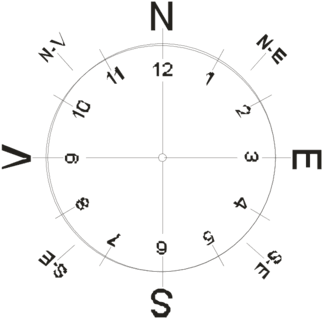

In [ ]:

def angle_to_number(angle):
    if 0 <= angle < 15:
        return 9
    elif 15 <= angle < 30:
        return '9:30'
    elif 30 <= angle < 45:
        return 10
    elif 45 <= angle < 60:
        return '10:30'
    elif 60 <= angle < 75:
        return 11
    elif 75 <= angle < 90:
        return '11:30'
    elif -90 <= angle < -75:
        return 12
    elif -75 <= angle < -60:
        return '12:30'
    elif -60 <= angle < -45:
        return 1
    elif -45 <= angle < -30:
        return '1:30'
    elif -30 <= angle < -15:
        return 2
    elif -15 <= angle < 0:
        return '2:30'    
    
    else:
        return 3  # Default case if angle is out of range

# **Function for Calculating Adaptive Threshold value**

In [7]:
def find_lowest_six_avg(matrix):
    matrix = np.array(matrix)
    flat_values = np.sort(matrix.flatten())
    lowest_six = flat_values[:6]
    # print(lowest_six)
    avg_lowest_six = np.mean(lowest_six)   
    return avg_lowest_six

# **Result**

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
import io
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tabulate import tabulate  # Import tabulate for timing output

MODEL_PATH = '/kaggle/input/midasv2/keras/default/1/Midas-V2.tflite'
try:
    interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
    interpreter.allocate_tensors()
    print("Model Loaded")

    # Check model details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("Input Details:", input_details)
    print("Output Details:", output_details)

except ValueError as e:
    print("Error loading the model:", e)


INPUT_HEIGHT = 256
INPUT_WIDTH = 256

INPUT_MEAN = 127.5
INPUT_STD = 127.5

MAX_IMAGE_SIZE = 65535  # Maximum allowed size for the image in bytes

# Preprocess image to match model input size and normalize
def preprocess_image(image: Image.Image) -> np.ndarray:
    original_size = image.size  # Store the original image size

    # Compress the image if its size is greater than 1 MB
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    size_in_mb = len(img_byte_arr.getvalue()) / (1024 * 1024)

    # If the image size exceeds 1 MB, we compress it
    if size_in_mb > 1.0:
        quality = int(min(85, 85 * (2.0 / size_in_mb)))  # Adjust quality based on size
        compressed_io = io.BytesIO()
        image.save(compressed_io, format='JPEG', quality=quality, optimize=True)
        image = Image.open(compressed_io)

    # Convert the image to RGB and resize to the input size
    image = image.convert('RGB')
    image = image.resize((INPUT_WIDTH, INPUT_HEIGHT))

    # Convert the image to a NumPy array and normalize
    image_np = np.array(image).astype(np.float32)
    image_np = (image_np - INPUT_MEAN) / INPUT_STD  # Normalize
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension

    return image_np, original_size

# Postprocess depth map to match original size
def postprocess_depth(depth: np.ndarray, original_size: tuple) -> Image.Image:
    depth = np.squeeze(depth)

    # Normalize the depth values to the range [0, 1]
    depth_min = depth.min()
    depth_max = depth.max()
    depth_normalized = (depth - depth_min) / (depth_max - depth_min)

    # Convert to a 0-255 range for visualization
    depth_image = (depth_normalized * 255).astype(np.uint8)

    depth_pil = Image.fromarray(depth_image)
    depth_pil = depth_pil.resize(original_size, Image.Resampling.LANCZOS)

    return depth_pil

# Calculate patch values for a 5x5 grid
def calculate_patch_values(depth_image: Image.Image) -> dict:
    depth_array = np.array(depth_image)
    h, w = depth_array.shape
    patch_values = {}
    patch_size_h = h // 5
    patch_size_w = w // 5

    for i in range(5):
        for j in range(5):
            patch = depth_array[i * patch_size_h:(i + 1) * patch_size_h,
                                j * patch_size_w:(j + 1) * patch_size_w]
            patch_values[5 * i + j + 1] = int(np.mean(patch))

    return patch_values

# Generate depth map from image
def generate_depth_from_image(image_filename):
    overall_start = time.time()

    try:
        timings = []

        step_start = time.time()
        image = Image.open(image_filename)
        image = ImageOps.exif_transpose(image)
        timings.append(["Image Loading", time.time() - step_start])

        step_start = time.time()
        input_data, original_size = preprocess_image(image)
        timings.append(["Preprocessing", time.time() - step_start])

        step_start = time.time()
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        timings.append(["Model Inference", time.time() - step_start])

        step_start = time.time()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        depth = output_data[0]
        timings.append(["Depth Map Extraction", time.time() - step_start])

        step_start = time.time()
        depth_image = postprocess_depth(depth, original_size)
        timings.append(["Postprocessing", time.time() - step_start])

        return {
            'depth_map': depth_image
        }

    except Exception as e:
        print(f"Error processing {image_filename}: {e}")
        return {'error': str(e)}

import os
from PIL import Image
import pandas as pd

# Define paths
dataset_path = ""
csv_path = '/kaggle/input/path-for-outdoor-final/outdoor_gt_path.csv'

# Load the CSV file and get the first column (image filenames)
image_files = pd.read_csv(csv_path, header = None)  # Read CSV file
gt_value = image_files.iloc[:, 1]
image_files2 = image_files.iloc[:, 0]  # Select the first column (image filenames)

# Create a list to store full image paths
full_paths = []
out_pred = []
# Iterate through the first 10 filenames and construct the full path
for filename in image_files2:
    image_path = os.path.join(dataset_path, filename)  # Construct full path
    full_paths.append(image_path)  # Store the full path in the list
    # print(f"Full path: {image_path}")

total_time = 0
total_images = len(full_paths)
overall_times = []
tot_times = []

for image_filename in full_paths:

    start_time = time.time()
    result = generate_depth_from_image(image_filename)
    image_path = result['depth_map']  # Replace with your image path

    # print(image_path)
    # image = Image.open(image_path)  # Load the image
    image_array = np.array(image_path) 
    # Convert image to patches and calculate average intensities
    # print(image_array)
    patch_matrix = image_to_patches(image_array, resize_to=(225, 225), patch_size=(15, 15))
    
    # print(patch_matrix)
    th = find_lowest_six_avg(patch_matrix)
    print("Threshold Value: ",th)
    # Starting point (row, col) for path visualization
    start_row, start_col = 14, 7
    
    # Perform the depth map search
    longest_straight_forward_path = depth_map_search(patch_matrix, start_row, start_col, th)
    
    # Display the results with the fitted line and slope
    result = display_results_with_line(image_array, patch_matrix, longest_straight_forward_path)

    end_time = time.time()
    tot_times.append(end_time-start_time)
    out_pred.append(result)
    
    
print(len(out_pred))
print(tot_times)
average_time = sum(tot_times) / len(tot_times)
print(f"Average response time: {average_time:.4f} seconds")

In [10]:
print((out_pred))

[10, '12:30', 10, 11, 11, 11, '12:30', '10:30', '1:30', 1, 10, 1, '9:30', '12:30', 1, 11, '9:30', '9:30', 11, 1, 3, '10:30', '9:30', '10:30', '12:30', '11:30', 11, '12:30', '11:30', '12:30', 10, 1, 10, '12:30', 11, 12, 11, 1, 3, '12:30', '10:30', 12, 1, 11, '11:30', 3, '9:30', 11, 11, 10, 1, 12, '10:30', 10, 1, '12:30', 1, 1, '12:30', 1, 12, '9:30', 11, 10, 11, 12, '12:30', '11:30', '11:30', '11:30', 12, '10:30', '10:30', '10:30', 10, '12:30', '2:30', 10, 3, 10, 1, '12:30', 10, 10, 11, 10, 12, 1, 12, '12:30', 10, 12, '11:30', '11:30', 1, '11:30', 1, '10:30', 11, 10, 11, 12, 11, '10:30', 12, 12, 11, 10, '10:30', 11, 10, 12, 12, 11, 1, '9:30', 10, 3, 11, '11:30', 12, 1, '10:30', '9:30', 12, 1, 10, 1, 11, '9:30', 3, 3, '11:30', '10:30', 10, 1, '12:30', 11, 12, 1, '10:30', '12:30', '12:30', 11, 11, 11, 10, 1, 12, 10, '10:30', 10, 11, 10, 1, '9:30', '12:30', '12:30', '12:30', '11:30', '12:30', 11, 11, '12:30', 11, '11:30', '12:30', '9:30', 12, '9:30', 11, 12, '12:30', '12:30', 11, '10:30', 

In [ ]:
def time_to_minutes(time_str):
    # Handle times like 12, 11:30, 10:30, etc.
    if ":" in time_str:  # For times like 12:30, 10:30, etc.
        hour, minute = map(int, time_str.split(":"))
    else:  # For times like 12, 11, 10, etc.
        hour, minute = int(time_str), 0
    
    # If hour is greater than or equal to 1, add 12 hours
    if hour == 1 or hour == 2 or hour == 3:
        hour += 12
    
    return hour * 60 + minute

def calculate_time_difference(gt_val, out_val):
    # Convert both gt_val and out_val to minutes
    gt_time_in_minutes = time_to_minutes(gt_val)
    out_time_in_minutes = time_to_minutes(out_val)

    # print(gt_time_in_minutes, out_time_in_minutes, similar_cnt)
    # Calculate the absolute difference
    return abs(gt_time_in_minutes - out_time_in_minutes)

# print(len(gt_value), len(out_pred))
out_pred = ['3' if val is None else val for val in out_pred]
# print(out_pred)
# Example for the 5 iterations
size = 300
tot_dig = 0
similar_cnt = 0
for i in range(size):
    gt_val = str(gt_value[i]).replace(" ", "")
    out_val = str(out_pred[i]).replace(" ", "")
    time_diff = calculate_time_difference(gt_val, out_val)
    # if time_diff <= 30:
    #     time_diff = 0
    if time_diff == 0:
        similar_cnt += 1
    tot_dig += time_diff * 0.5

print("MAE:", tot_dig / size, "degree")
print("Accuracy:", (similar_cnt / size) * 100, "%")

MAE: 34.45 degree
Accuracy: 34.66666666666667 %
